# Run phylogenetic scan for mutations enriched in different hosts

This notebook will read in the analyses coded in `calculate-enrichment-scores` and `simulate-mutation-gain-loss-markov-chain` and run them. 

In [1]:
import glob, json
import re,copy, imp
import pandas as pd 
import numpy as np
import time

import rpy2
%load_ext rpy2.ipython

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

In [18]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run calculate-enrichment-scores-across-tree-JSON.ipynb
%run simulate-mutation-gain-loss-markov-chain.ipynb

In [3]:
from datetime import date
current_date = str(date.today())

In [4]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

# Infer mutations on tree and calculate enrichment scores

There are 2 main choice here: the minimum required count, and the method. For every amino acid on the tree, the enrichment score will not be returned if it is present in less than `minimum required count` tips. I have arbitrarily set this to 5 currently, but it could be another number. For the method, there are 2: `proportions` and `counts`. In `counts`, we calculate an odds ratio as: `(A*D)/(B*C)`, where `A`,`B`,`C`, and `D` are counts of tips. In `proportions`, we calculate `(A+D)-(B+C)` where the cells are the proportion of total tips in each category. 

There are a few outputs: the `times_detected_dict` outputs the number of times that the mutation arose on the tree. The counts in `scores_dict` represent the number of tips with each mutation. 

To run this on amino acids, put in the gene name under `gene`. To run on nucleotide mutations, replace gene with `nuc`. 

In [12]:
#tree_path = "/Users/lmoncla/src/h5n1-host-classification/avian-flu-k99/old-and-test-subsamplings/auspice/flu_avian_h5n1_pb2.json"
tree_path = "/Users/lmoncla/src/h5n1-gwas/test-data/flu_avian_h5n1_pb2.json"
#tree_path = "/Users/lmoncla/src/h5n1-gwas/test-data/flu_avian_h5n1_ha.json"

gene = "PB2"
host1 = "human"
host2 = "domestic"
minimum_required_count = 2
method = "counts"

In [13]:
tree = read_in_tree_json(tree_path)


Tree height: 43.599223
Tree length: 1211.061179
annotations present

Numbers of objects in tree: 1328 (603 nodes and 725 leaves)



In [14]:
nonzero_branches = 0
for k in tree.Objects:
    divergence = k.traits['node_attrs']['div']

    # if this happens at the root, set parent divergence to 0
    if k.parent.traits == {}:
        parent_div = 0
    else:
        parent_div = k.parent.traits['node_attrs']['div']
        
    branch_length = divergence - parent_div
    if branch_length > 0: 
        nonzero_branches += 1

print(nonzero_branches)

1195


In [15]:
aa_muts, nt_muts = gather_all_mut_on_tree(tree, gene)
print(len(aa_muts))
print(len(nt_muts))

837
2587


In [16]:
total_host_tips_on_tree = return_all_host_tips(tree)
print(total_host_tips_on_tree)

total_tree_branch_length, tree_branch_lengths = return_total_tree_branch_length(tree)
print(total_tree_branch_length)

{'human': 137, 'domestic': 437, 'wild': 151}
3.9037714008823867


In [19]:
# calculate enrichment scores for all mutations along the tree
# must set method to be counts or proportions
scores, scores_dict, times_detected_dict, branch_lengths_dict, host_counts_dict2 = calculate_enrichment_scores(tree, aa_muts, nt_muts, host1, host2, minimum_required_count, method, total_host_tips_on_tree)

In [20]:
print(len(scores_dict))

294


In [21]:
print(np.min(scores))
print(np.mean(scores))
print(np.median(scores))
print(np.max(scores))

0.0
1.7229545121026302
0.7665049665049665
27.03875968992248


### Now do simulations

The `min_required_count_sims` should be the same number as the above `minimum_required_count`

The output for `sims_times_detected` will be the number of times in each iteration that the simulated mutation arose. This includes occurrences on internal nodes and on terminal nodes. 

In [56]:
iterations = 10000
min_required_count_sims = 2

start_time = time.time()

sim_scores, sim_times_detected, branches_that_mutated = perform_simulations(tree, gene, iterations, total_tree_branch_length, host1, host2, min_required_count_sims, method)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
total_time_hours = total_time_minutes/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes,", total_time_hours," hours) to generate", iterations, "simulated trees")

this took 1569.9207208156586 seconds ( 26.165345346927644  minutes, 0.43608908911546074  hours) to generate 10000 simulated trees


In [57]:
simulated = sim_scores

In [58]:
print(np.min(simulated))
print(np.mean(simulated))
print(np.median(simulated))
print(np.max(simulated))
print(np.percentile(simulated, 0.025), np.percentile(simulated, 97.5))
print(type(simulated))

0.0
1.4709764775488088
0.5281862745098039
26.741803278688526
0.0 9.707974137931034
<class 'list'>


In [59]:
percentile_95 = np.percentile(simulated, 95)
percentile_99 = np.percentile(simulated, 99)
percentile_999 = np.percentile(simulated, 99.9)
percentile_9999 = np.percentile(simulated, 99.99)

print(percentile_95, percentile_99, percentile_999, percentile_9999)

6.45925925925926 13.142857142857142 20.494444444444444 26.741803278688526


In [60]:
print(scores_dict["E627K"], host_counts_dict2['E627K'])
print(scores_dict["I292T"], host_counts_dict2['I292T'])

#print(scores_dict["G1906A"], host_counts_dict2['G1906A'])

#print(scores_dict['A150V'], host_counts_dict2['A150V'])

1.9716594827586207 {'human': 57, 'domestic': 116, 'wild': 40}
3.8230088495575223 {'human': 24, 'domestic': 23, 'wild': 5}


In [61]:
"""correct for multiple testing"""
significance_threshold = 0.05 #/len(scores_dict)

percentile_of_significance = 100-(significance_threshold*100)
significant_score = np.percentile(simulated,percentile_of_significance)

print(significance_threshold, percentile_of_significance, significant_score)

0.05 95.0 6.45925925925926


In [62]:
print(len(scores_dict))
high_scores = {}
significant = 0

for s in scores_dict:
    if scores_dict[s] > np.percentile(simulated, percentile_of_significance):
    #if scores_dict[s] > np.max(simulated):
    #if scores_dict[s] > np.percentile(simulated, 95):
        print(s, scores_dict[s], times_detected_dict[s], host_counts_dict2[s])
        significant += 1
        high_scores[s] = [scores_dict[s]]
        
print(significant)

294
E687K 13.142857142857142 2 {'human': 4, 'domestic': 0, 'wild': 0}
P465S 16.466124661246614 2 {'human': 14, 'domestic': 3, 'wild': 0}
E391Q 6.474074074074074 2 {'human': 2, 'domestic': 0, 'wild': 1}
K586R 8.238636363636363 2 {'human': 5, 'domestic': 2, 'wild': 1}
K187R 9.761194029850746 3 {'human': 3, 'domestic': 1, 'wild': 1}
T524I 16.528695652173912 2 {'human': 22, 'domestic': 5, 'wild': 1}
T521A 8.238636363636363 3 {'human': 5, 'domestic': 2, 'wild': 2}
I411M 9.761194029850746 4 {'human': 3, 'domestic': 1, 'wild': 1}
G685R 6.474074074074074 3 {'human': 2, 'domestic': 0, 'wild': 1}
E517K 13.142857142857142 1 {'human': 4, 'domestic': 0, 'wild': 0}
D701N 27.03875968992248 9 {'human': 8, 'domestic': 1, 'wild': 0}
I480V 13.142857142857142 1 {'human': 4, 'domestic': 0, 'wild': 0}
Q447L 9.783582089552239 1 {'human': 3, 'domestic': 0, 'wild': 0}
R288Q 15.641379310344828 1 {'human': 21, 'domestic': 5, 'wild': 1}
T178A 6.474074074074074 2 {'human': 2, 'domestic': 0, 'wild': 1}
15


In [24]:
sim_scores_df = pd.DataFrame(simulated, columns = ["score"])
sim_scores_df.head()

,score
0,0.000000
1,0.000000
2,2.239423
3,0.000000
4,0.000000


In [25]:
actual_scores_df = pd.DataFrame.from_dict(scores_dict, orient="index")
actual_scores_df.reset_index(inplace=True)
actual_scores_df.columns = ['mutation','score']
print(len(actual_scores_df))
actual_scores_df.head()

294


,mutation,score
0,N556S,1.063725
1,A588V,1.063725
2,I529V,1.375267
3,T451I,1.063725
4,I67V,0.624242


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


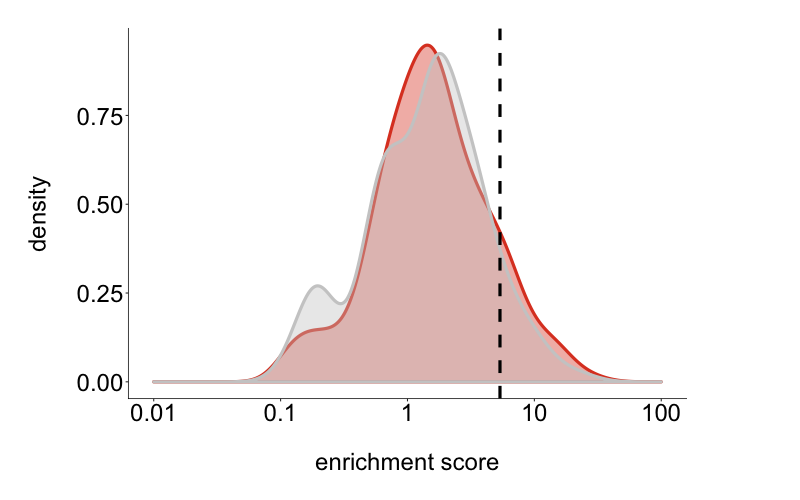

In [26]:
%%R -w 800 -h 500 -u px -i actual_scores_df,sim_scores_df,significant_score,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("PB2-gwas-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_density(data=actual_scores_df, aes(x=score), alpha=0.4, size=1.5, color=human_color, fill=human_color)+
    geom_density(data=sim_scores_df, aes(x=score), alpha=0.4, size=1.5, color="grey80", fill="grey80")+
    geom_vline(aes(xintercept=significant_score), linetype="dashed", size=1.5, color="black")+
    labs(x="\nenrichment score", y="density\n")+
#     scale_color_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=domestic_color,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=human_color), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_fill_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=NA,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=NA), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_linetype_manual(values=c(wild_to_domestic_data="solid",wild_to_domestic_shuffled_dates="dashed",domestic_to_human_data="solid", domestic_to_human_shuffled_dates="dashed"), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_log10(limits=c(0.01,100), breaks=c(0.01,0.1,1,10,100), labels=c("0.01","0.1","1","10","100"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+  
    theme(strip.text.x=element_text(size=24))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", hjust=0.5))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.text=element_text(size=30))+
    theme(legend.title=element_blank())

    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 9, height = 6, device = "pdf", path = "../figures", dpi = 300)
p

## Plot mutations vs. branch length 

This is just to check to make sure that the number of times a branch mutates in the simulations is proportional to its branch length. 

In [27]:
# branches that mutated is output from the simulations and represents the total number of times a branch was mutated
# during the course of the simulations; it is a dictionary that starts at 0 and adds a count each time the simulation
# is run
df1 = pd.DataFrame.from_dict(branches_that_mutated, orient="index")
df1.reset_index(inplace=True)
df1.head()

,index,branch_length,times_mutated
0,A/Alberta/1/2014,0.002601,1
1,A/Americangreen-wingedteal/Washington/195750/2014,0.000865,1
2,A/Bangladesh/207095/2008,0.001313,1
3,A/Bangladesh/5487/2011,0.002608,2
4,A/Beijing/1/2003,0.002981,1


From playing with this a little bit, when we run 100 simulations, we get mutations on about 100 branches. If we run 1000, we get mutations on ~500 branches. Ideally, we would want to simulate such that we capture getting a mutation on most non-zero branch length branches in the tree. This number is 1195. So we need to do a lot more simulations if we'd like to capture getting a mutation on most branches. When I ran 10,000 sims, we mutated 1071 branches, which is pretty close. 

In [28]:
# print the minimum and maximum times a branch mutated, along with the unique branches that did mutate 
# there are 1328 objects in the tree
print(min(df1["times_mutated"]), max(df1["times_mutated"]))
print(len(set(df1['index'].tolist())))

1 18
516


In [29]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

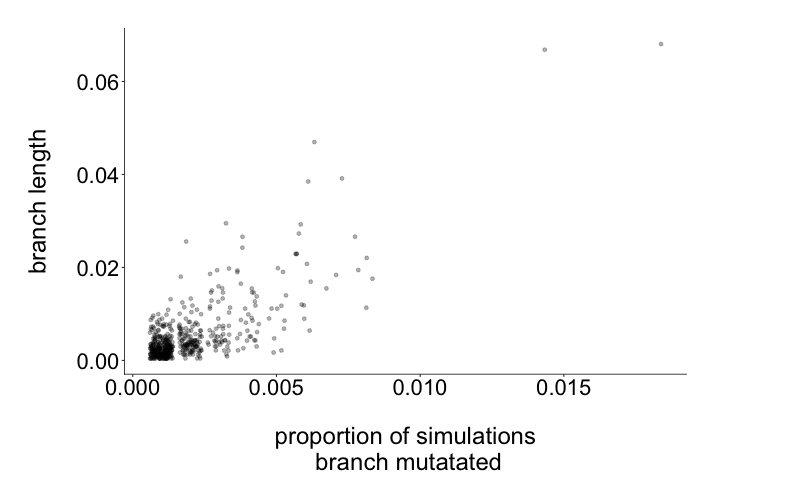

In [30]:
%%R -w 800 -h 500 -u px -i df1,iterations,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("muts-vs-bl-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=df1, aes(x=times_mutated/iterations, y=branch_length), color="black",alpha=0.3)+
    #geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    #geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    labs(x="\nproportion of simulations\n branch mutatated",y="branch length\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 7, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

## Compare the distribution of times a site mutates in the simulation to the actual data 

In theory, we should be capturing a similar mean distribution of the number of times a site will mutate in our simulation vs. our data. I'd like to see if that is true. 

In [31]:
# convert to dataframe and transpose
times_detected_df = pd.DataFrame([times_detected_dict]).T
times_detected_df.reset_index(inplace=True)
times_detected_df.columns = ["mutation","times_detected"]
times_detected_df['source'] = "data"
times_detected_df.head()

,mutation,times_detected,source
0,*760Y,1,data
1,A105T,2,data
2,A108T,1,data
3,A108V,5,data
4,A152S,3,data


In [32]:
# PB2 has 759 amino acids in it 
all_muts = set(times_detected_df['mutation'].tolist())
all_sites = []

for a in all_muts: 
    site = a[1:-1]
    all_sites.append(site)
    
all_sites = set(all_sites)
print(len(all_sites))

479


In [33]:
# so, 280 sites never mutated; we need to add that to the dataframe 
non_mutated_df = pd.DataFrame(index=np.arange(759-479), columns=np.arange(3))
non_mutated_df.columns = ["mutation","times_detected","source"]
non_mutated_df['mutation'] = "A"
non_mutated_df['times_detected'] = 0
non_mutated_df['source'] = 'data'
non_mutated_df.head()

,mutation,times_detected,source
0,A,0,data
1,A,0,data
2,A,0,data
3,A,0,data
4,A,0,data


In [36]:
# convert to dataframe and transpose
sim_times_detected_df = pd.DataFrame(sim_times_detected).T
sim_times_detected_df.reset_index(inplace=True)
sim_times_detected_df["source"] = "simulated"
sim_times_detected_df.columns = ["mutation","times_detected","source"]
sim_times_detected_df.head()

,mutation,times_detected,source
0,0,1,simulated
1,1,1,simulated
2,2,2,simulated
3,3,3,simulated
4,4,1,simulated


In [37]:
# combine
combined_times_detected_df = times_detected_df.append(sim_times_detected_df).append(non_mutated_df)
combined_times_detected_df.head()

,mutation,times_detected,source
0,*760Y,1,data
1,A105T,2,data
2,A108T,1,data
3,A108V,5,data
4,A152S,3,data


In [38]:
# convert to proportions 
x = pd.DataFrame(times_detected_df.append(non_mutated_df)['times_detected'].value_counts())
x.reset_index(inplace=True)
x.columns = ['times_detected_on_tree','number_of_mutations']
x['source'] = 'data'
x['proportion_of_mutations'] = x['number_of_mutations']/len(times_detected_df)
x.head()

,times_detected_on_tree,number_of_mutations,source,proportion_of_mutations
0,1,507,data,0.605735
1,0,280,data,0.334528
2,2,154,data,0.183990
3,3,59,data,0.070490
4,4,35,data,0.041816


In [41]:
%%R -w 800 -h 500 -u px -i combined_times_detected_df,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("times-mutated-data-vs-sims-",current_date,".pdf", sep="")

# adding in the y = stat(count / sum(count)) will make the y-axis be proportions instead of counts

p <- ggplot() + 
    geom_histogram(data=combined_times_detected_df, aes(x=times_detected, y = stat(count / sum(count), color=source, fill=source), position="dodge", binwidth=1, size=0.2)+
    labs(x="\nnumber of times site mutated",y="proportion of sites\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(0.5, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
p


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:34:1: unexpected symbol
33: #ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
34: p
    ^


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:34:1: unexpected symbol
33: #ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
34: p
    ^

  warnings.warn(x, RRuntimeWarning)


## Thoughts 

I am not mutating as much as the actual data. So in my simulations, I am getting more sites with 0 mutations and fewer sites with 1 mutation than is in my actual data. 

# Compare to DMS values

A reasonable comparison should be to see whether any of these PB2 mutations scored well in [Shirleen's PB2 DMS paper.](https://elifesciences.org/articles/45079). I'd like to see whether the mutations I find as significant have generally negative or positive DMS values. 

In [42]:
def return_times_detected_mut(mutation, times_detected_dict):
    if mutation in times_detected_dict: 
        times_detected = times_detected_dict[mutation]
    else:
        times_detected = 0
        
    return(times_detected)

In [43]:
def read_in_dms_preferences(dms_file):
    
    mut_prefs = {}
    
    with open(dms_file, "r") as infile: 
        for line in infile: 
            site = line.split(",")[0]
            wt = line.split(",")[1]
            mut = line.split(",")[2]
            mut_diff_sel = line.split(",")[11]

            full_mut = wt + site + mut
            mut_prefs[full_mut] = mut_diff_sel

    return(mut_prefs)

In [44]:
def return_dms_pref(mutation, mut_prefs):
    if mutation in mut_prefs:
        preference = mut_prefs[mutation]
    else:
        #print(mutation)
        preference = None
    
    return(preference)

In [45]:
def read_in_previously_identified(known_muts_file):
    
    known_muts = {}
    
    with open(known_muts_file, "r") as infile: 
        for line in infile: 
            site = line.split("\t")[0]
            full_mut = line.split("\t")[1]
            source = line.split("\t")[2]
            verified = line.split("\t")[3]
            strain = line.split("\t")[6].strip()

            known_muts[full_mut] = {"source":source, "verified":verified, "strain":strain}
    
    return(known_muts)

In [46]:
def return_known_muts(mutation, known_muts):
    if mutation in known_muts: 
        annotation = "known"
    else:
        annotation = "not"
        
    return(annotation)

In [47]:
def return_known_muts_method(mutation, known_muts):
    if mutation in known_muts: 
        annotation = known_muts[mutation]['source'] + "_" + known_muts[mutation]['verified']
    else:
        annotation = "not"
        
    return(annotation)

In [48]:
def return_labels(mutation, muts_to_label_list):
    if mutation in muts_to_label_list:
        label = str(mutation)
    else:
        label = ""
    return(label)

In [49]:
dms_file = "../data/summary_prefs_effects_diffsel.csv"
known_muts_file = "../data/Soh-elife-previously-validated-muts.tsv"

dms_prefs = read_in_dms_preferences(dms_file)
known_muts = read_in_previously_identified(known_muts_file)

In [50]:
DMS_list = [9,82,163,176,182,183,292,355,521,522,532,534,627,669,701,112,378,382]
muts_to_label = ["E627K","D701N","K526R","I292T"]

In [51]:
actual_scores_df['significant'] = np.where(actual_scores_df['score'] > significant_score, "significant", "not")
actual_scores_df['times_detected'] = actual_scores_df['mutation'].apply(return_times_detected_mut,args=[times_detected_dict])
actual_scores_df['DMS_prefs'] = actual_scores_df['mutation'].apply(return_dms_pref, args=[dms_prefs])
actual_scores_df['known'] = actual_scores_df['mutation'].apply(return_known_muts, args=[known_muts])
actual_scores_df['known_how'] = actual_scores_df['mutation'].apply(return_known_muts_method, args=[known_muts])
actual_scores_df['label'] = actual_scores_df['mutation'].apply(return_labels, args=[muts_to_label])


#actual_scores_df = actual_scores_df.melt(id_vars=['mutation',"score"])
actual_scores_df.head()

,mutation,score,significant,times_detected,DMS_prefs,known,known_how,label
0,N556S,1.063725,not,4,-0.1498271541416584,not,not,
1,A588V,1.063725,not,5,0.7220976919937024,not,not,
2,I529V,1.375267,not,1,0.5345603394447391,not,not,
3,T451I,1.063725,not,4,None,not,not,
4,I67V,0.624242,not,9,-0.050188595574662855,known,Natural_No,


In [52]:
actual_scores_df['DMS_prefs'] = pd.to_numeric(actual_scores_df['DMS_prefs'])
actual_scores_df.head()

,mutation,score,significant,times_detected,DMS_prefs,known,known_how,label
0,N556S,1.063725,not,4,-0.149827,not,not,
1,A588V,1.063725,not,5,0.722098,not,not,
2,I529V,1.375267,not,1,0.534560,not,not,
3,T451I,1.063725,not,4,NaN,not,not,
4,I67V,0.624242,not,9,-0.050189,known,Natural_No,


In [53]:
sloth = actual_scores_df[actual_scores_df['significant'] == "significant"]
#sloth = actual_scores_df[actual_scores_df['known'] == "known"]

sloth

,mutation,score,significant,times_detected,DMS_prefs,known,known_how,label
30,D195N,5.656168,significant,6,-0.272543,not,not,
72,E687K,13.142857,significant,2,0.557936,not,not,
78,P465S,16.466125,significant,2,-0.741246,not,not,
82,E391Q,6.474074,significant,2,1.123364,not,not,
94,S225G,6.459259,significant,2,0.179218,not,not,
95,K586R,8.238636,significant,2,0.821765,not,not,
108,K187R,9.761194,significant,3,NaN,not,not,
160,T524I,16.528696,significant,2,0.207429,not,not,
186,T521A,8.238636,significant,3,-0.580538,not,not,
199,I498V,6.459259,significant,3,0.440327,not,not,


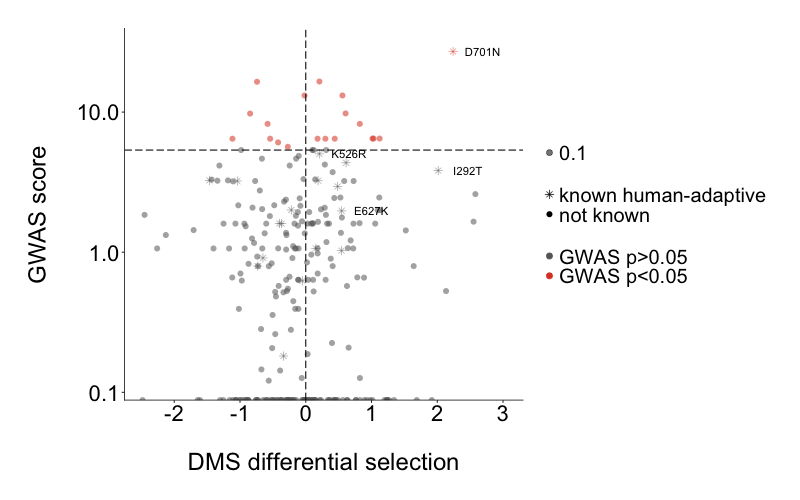

In [54]:
%%R -w 800 -h 500 -u px -i actual_scores_df,percentile_95,percentile_99,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

actual_scores_df$DMS_prefs = as.numeric(actual_scores_df$DMS_prefs)
output_filename = paste("pb2-scores-vs-dms-prefs2-human-domestic-OR-",current_date,".pdf", sep="")

p <- ggplot(data=actual_scores_df, aes(y=score, x=DMS_prefs, shape=known)) + 
    #geom_violin()+
    geom_jitter(aes(color=significant, alpha=0.1), size=2.5)+
    geom_hline(aes(yintercept=percentile_95), linetype=5)+
    geom_vline(aes(xintercept=0), linetype=5)+
    geom_label(data=actual_scores_df, aes(x=DMS_prefs+0.45,y=score, label=label),label.size=NA, size=4, fill=NA)+
    labs(x="\nDMS differential selection",y="GWAS score\n")+
    scale_color_manual(values=c(not="grey40",significant=human_color), labels=c(not="GWAS p>0.05", significant="GWAS p<0.05"))+
    scale_shape_manual(values=c(known=8,not=16), labels=c(known="known human-adaptive", not="not known"))+
    scale_y_log10(limits=c(-0.01,30))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

In [222]:
x = actual_scores_df[actual_scores_df['times_detected'] > 1]
true_pos = len(actual_scores_df[(actual_scores_df['score'] > percentile_95) & (actual_scores_df['DMS_prefs'] > 0)])
false_pos = len(actual_scores_df[(actual_scores_df['score'] > percentile_95) & (actual_scores_df['DMS_prefs'] < 0)])
true_neg = len(actual_scores_df[(actual_scores_df['score'] < percentile_95) & (actual_scores_df['DMS_prefs'] < 0)])
false_neg = len(actual_scores_df[(actual_scores_df['score'] < percentile_95) & (actual_scores_df['DMS_prefs'] > 0)])
print(true_pos, false_pos, true_neg, false_neg)

22 31 184 135


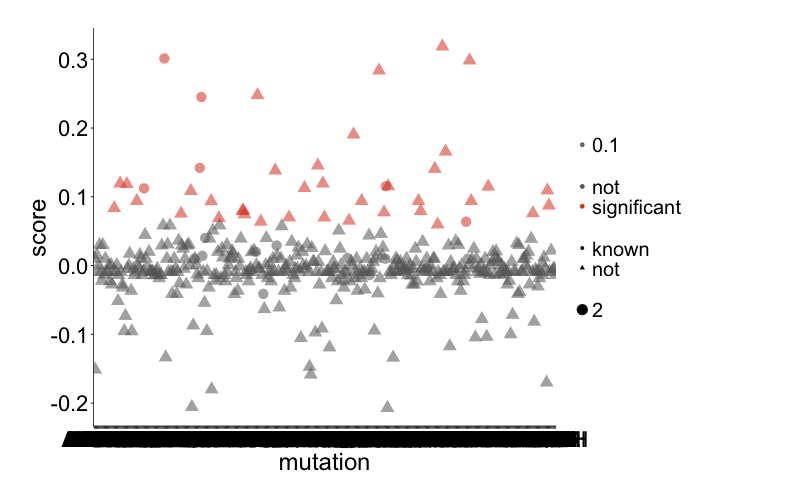

In [170]:
%%R -w 800 -h 500 -u px -i actual_scores_df,percentile_95,percentile_99,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("pb2-scores-dots-",current_date,".pdf", sep="")

p <- ggplot(data=actual_scores_df, aes(x=mutation, y=score, color=significant, shape=DMS)) + 
    #geom_violin()+
    geom_jitter(aes(color=significant, alpha=0.1, size=2))+
#     geom_hline(aes(yintercept=percentile_95), linetype=5)+
#     geom_hline(aes(yintercept=percentile_99), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    #labs(x="",y="circulation time (years)\n")+
     scale_color_manual(values=c(not="grey40",significant=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

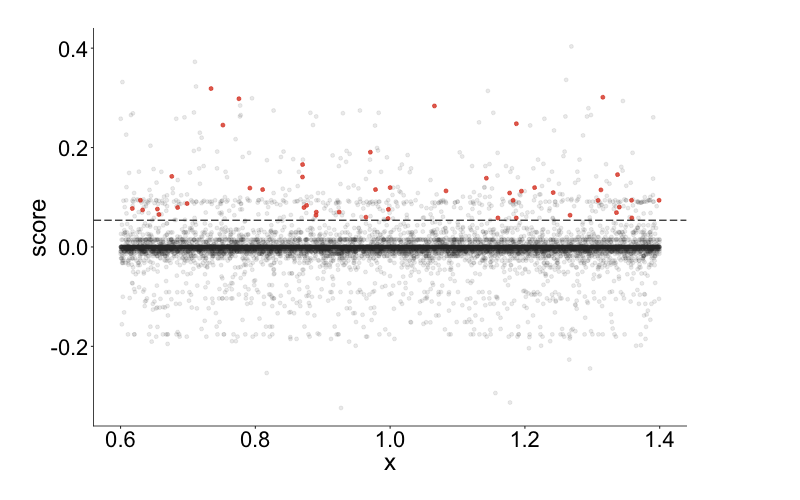

In [292]:
%%R -w 800 -h 500 -u px -i sim_scores_df,high_scores_df,percentile_95,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("pb2-scores-dots-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=sim_scores_df, aes(x=1, y=score), color="grey20",alpha=0.1)+
    geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    #labs(x="",y="circulation time (years)\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 6, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

## Plot a tree with branches colored by number of times they mutated in my simulation

In [263]:
df1 = pd.DataFrame.from_dict(branches_that_mutated, orient="index")
df1.reset_index(inplace=True)
df1.head()

,index,branch_length,times_mutated
0,A/Americanwigeon/Washington/196340/2015,0.001298,1
1,A/Cambodia/V0219301/2011,0.002572,1
2,A/Cambodia/W0526301/2012,0.002586,1
3,A/Chicken/Henan/210/2004,0.039149,1
4,A/Chicken/Turkey-Isparta/09rs2841-37/2006,0.004334,1


In [264]:
print(min(df1["times_mutated"]), max(df1["times_mutated"]))
print(len(set(df1['index'].tolist())))

1 3
101


In [265]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

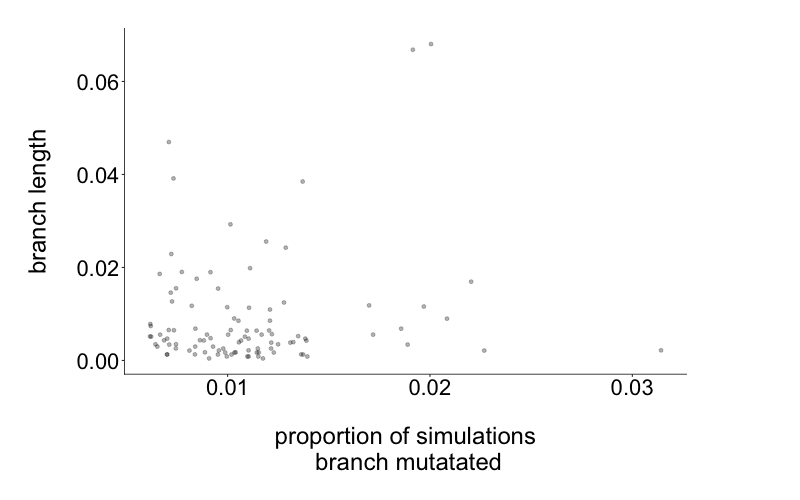

In [267]:
%%R -w 800 -h 500 -u px -i df1,iterations,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("muts-vs-bl-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=df1, aes(x=times_mutated/iterations, y=branch_length), color="black",alpha=0.3)+
    #geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    #geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    labs(x="\nproportion of simulations\n branch mutatated",y="branch length\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 7, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

In [145]:
def plot_tree(width, length, tree, filename, muts_dict, maximum):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    colors = clr.LinearSegmentedColormap.from_list('custom ', [wild_color, domestic_color], N=maximum)

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1975
    dates_ls = []
    for i in np.arange(min_date,2020,5):
        dates_ls.append(i) 
    [ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates_ls]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::2]:
    #     date_labels.append(dates_dict[d]['label'])
    #     if d < 2020:
    #         date_labels.append("")

    branchWidth=1.25 ## default branch width
    tipSize = 15

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        #print(muts_dict[k], (muts_dict[k])/maximum, colors(((muts_dict[k])/maximum)))
       
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        if muts_dict[k] == 0:
            c = "black"
#         elif muts_dict[k] > 10:
#             c = "blue"
#         else:
#             c = "green"
            
        if k.parent not in muts_dict:
            parent_color = "black"
#         elif muts_dict[k.parent] == 0:
#             parent_color = "black"
#         elif muts_dict[k.parent] > 10:
#             parent_color = "blue"
#         else:
#             parent_color = "green"

        if k.branchType=='leaf': ## if leaf...        
            #c=colors((muts_dict[k])/maximum)
            s=tipSize
            #parent_color = colors((muts_dict[k.parent])/maximum)
            a=1

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                #c=colors((muts_dict[k])/maximum)
                a=1
                #parent_color = colors((muts_dict[k.parent])/maximum)
            else:
                print("root")
                c="black"
                a=1
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        # add in a legend
        han_list = []

    # put in color bar
    # these coordinates are right, bottom, width, length
    ax3 = fig.add_axes([0.0, 0.30, 0.05, 0.25])   
    mpl.colorbar.ColorbarBase(ax3, cmap=colors)
    ax3.tick_params(size=2,labelsize=18)
    ax3.set_title('number times mutated', size=18)
    
    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.1, 0.2], loc=3,prop={'size': 16}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename)

    plt.show()

root


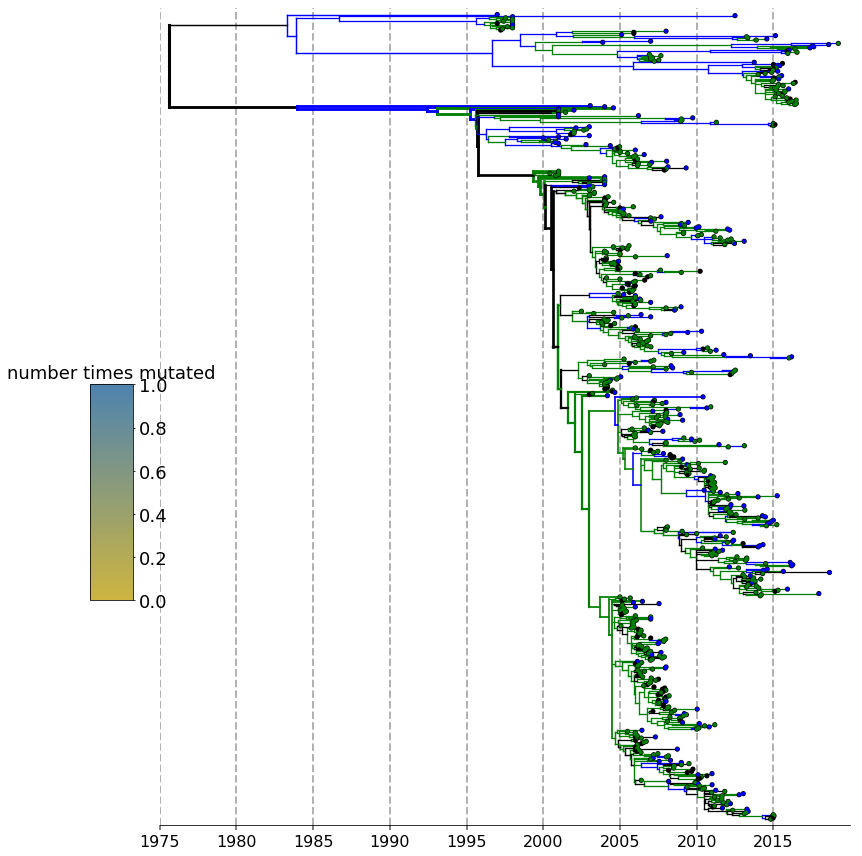

In [146]:
filename = "PB2-tree-by-sim-muts.pdf"
width = 12
length = 12
maximum = 181

plot_tree(width, length, tree, filename, muts_by_bl_dict, maximum)

In [714]:
from collections import defaultdict

In [717]:
slothattack = defaultdict(int)
slothattack[9] += 1

In [718]:
print(slothattack)

defaultdict(<class 'int'>, {9: 1})
